## How did public interest and sentiment in the #MeToo movement evolve over time?

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import pandas as pd
import requests as rq
from googleapiclient.discovery import build
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

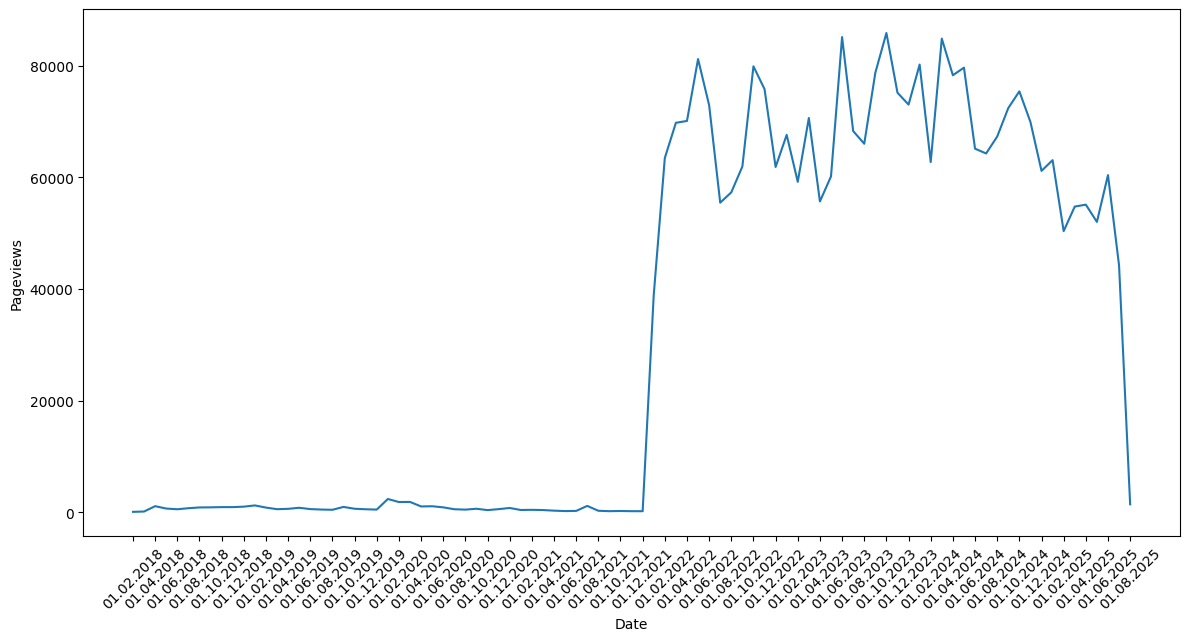

In [2]:
headers = {
    "User-Agent": "Wikimedia Analytics(Dianer)",}
view_url = """https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/all-agents/MeToo_movement/monthly/20160101/20250801"""
view_response = rq.get(view_url, headers=headers).json()

view_df = pd.DataFrame.from_records(view_response["items"])
# Convert timestamp column into a datetime and formats it to a string for better readability
view_df["timestamp"] = pd.to_datetime(view_df["timestamp"], format="%Y%m%d%H")
view_df["timestamp"]  = view_df["timestamp"].dt.strftime('%d.%m.%Y')

# Set index and drop unneeded columns
view_df = view_df.set_index("timestamp")
view_df = view_df.drop(columns=["project", "article", "granularity", "access", "agent"])

view_df.to_csv("wikipedia_meToo_data.csv", encoding="utf-8")

# Shows the pageviews over time
plt.figure(figsize=(12,6))
plt.plot(view_df.index, view_df['views'])
plt.xlabel("Date")
plt.ylabel("Pageviews")
plt.tight_layout()
plt.xticks(view_df.index[::2], rotation=45)
plt.show()

In [ ]:
api_key = ""
youtube = build("youtube", "v3", developerKey= api_key)

def flatten(xss):
    ''' Function that flattens one list
       i: list in list
       o: list'''
    return [x for xs in xss for x in xs]

def search_video(before=None, after=None, filename="input.csv"):
    ''' Searches youtube videos with given parameters
       and saves them as a csv'''
    all_videos = []
    next_page_token = None
    max_pages = 1
    current_page = 0

    # Iterates through max_pages pages and returns the videos
    while current_page < max_pages:
        parameters = {
            "q": "#MeToo",
            "maxResults": 50,
            "part": "snippet",
            "order": "relevance",
            "type": "video",
             "videoCategoryId": "25" # Politics and news
        }
        if before is not None:
            parameters["publishedBefore"] = before
        if after is not None:
            parameters["publishedAfter"] = after
        if next_page_token:
            parameters["pageToken"] = next_page_token

        request = youtube.search().list(**parameters)
        response = request.execute()
        all_videos.extend(response["items"])

        next_page_token = response.get("nextPageToken")
        current_page += 1

    # List of video ids
    ids = []
    for item in all_videos:
        ids.append(item["id"]["videoId"])

    # List of titles    
    titles = []
    for item in all_videos:
        titles.append(item["snippet"]["title"])

    # List of comments for each video
    all_comments = []
    for videoid in ids:
        video_comments = []
        try:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=videoid,
                maxResults=100,
                textFormat="plainText",
                order="relevance"
            )
            response = request.execute()
            for c in response.get("items", []):
                video_comments.append(c["snippet"]["topLevelComment"]["snippet"]["textDisplay"])

        # Comments may be disabled
        except Exception as e:
            continue

        all_comments.append(video_comments)

    # Comments are list in list    
    comments = flatten(all_comments)
    
    final_data = titles + comments
    
    df = pd.DataFrame(final_data, columns=["text"])
    df.to_csv(filename, index=False, encoding="utf-8")
    return final_data



In [5]:
def calculate_sentiment(data, filename1="counts.csv", filename2="score.csv"):
    '''Calculates the sentiment (positive, neutral, negative)
       of each video title + comment in the input data'''
    
    analyzer = SentimentIntensityAnalyzer()
    counts = {"positive": 0, "neutral": 0, "negative": 0}

    # Loops through each title/comment in the dataset
    for text in data:
        # Gets the compound sentiment score for the text
        score = analyzer.polarity_scores(text)["compound"]
    
        if score >= 0.05:
            counts["positive"] += 1
        elif score <= -0.05:
            counts["negative"] += 1
        else:
            counts["neutral"] += 1

    counts_df = pd.DataFrame([counts])
    counts_df.to_csv(filename1, index=False, encoding="utf-8")








In [6]:
data1 = search_video(before="2021-06-01T00:00:00Z", after="2018-01-01T00:00:00Z", filename="beforeHypeRawData.csv")
calculate_sentiment(data1, "sentimentBeforeHype.csv")
data2 = search_video(before="2022-01-01T00:00:00Z", after="2021-06-01T00:00:00Z", filename="earlyHypeData.csv")
calculate_sentiment(data2, "sentimentEarlyHype.csv")
data3 = search_video(before="2023-01-01T00:00:00Z", after="2022-01-01T00:00:00Z", filename="peakHypeData.csv")
calculate_sentiment(data3, "sentimentPeakHype.csv")
data4 = search_video(before="2024-01-01T00:00:00Z", after="2023-01-01T00:00:00Z", filename="sustainedHypeRawData.csv")
calculate_sentiment(data4, "sentimentSustainedHype.csv")
data5 = search_video(after="2024-01-01T00:00:00Z", filename="declineHypeRawData.csv")
calculate_sentiment(data5, "sentimentDeclineHype.csv")


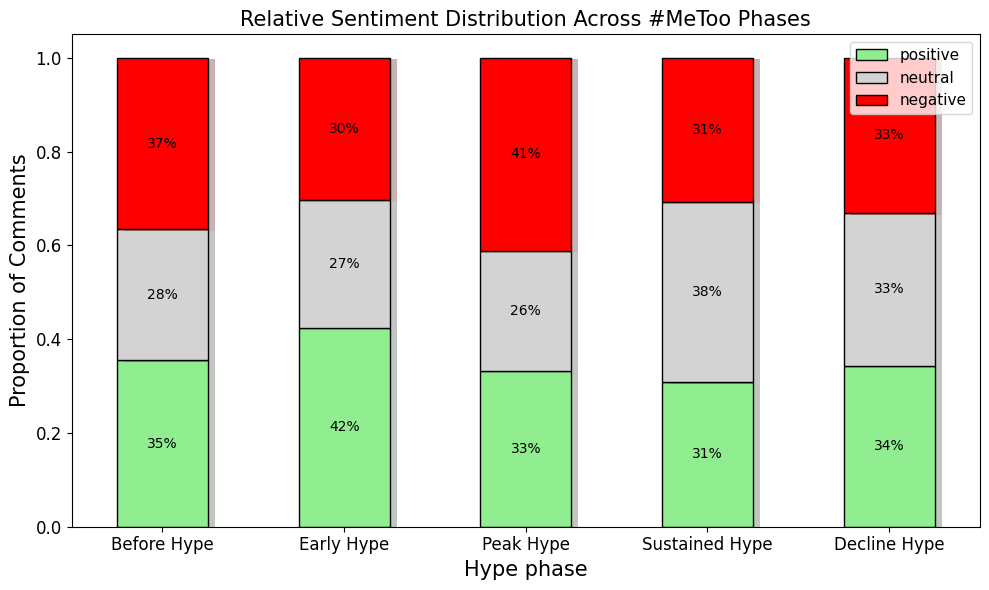

In [36]:
# Get the sentiment ratio of each data and put them into one dataframe
before = pd.read_csv("sentimentBeforeHype.csv")
before["phase"] = "Before Hype"
early = pd.read_csv("sentimentEarlyHype.csv")
early["phase"] = "Early Hype"
peak = pd.read_csv("sentimentPeakHype.csv")
peak["phase"] = "Peak Hype"
sustained = pd.read_csv("sentimentSustainedHype.csv")
sustained["phase"] = "Sustained Hype"
decline = pd.read_csv("sentimentDeclineHype.csv")
decline["phase"] = "Decline Hype"

df = pd.concat([before, early, peak, sustained, decline], ignore_index=True)


df_prop = df.set_index("phase")[["positive","neutral","negative"]]
# Normalizes each row, so total = 1
df_prop = df_prop.div(df_prop.sum(axis=1), axis=0)  

# Constructs a stacked bar plot
ax = df_prop.plot(kind="bar", stacked=True, figsize=(10,6), color=["lightgreen", "lightgray", "red"], edgecolor='black', path_effects=[path_effects.SimplePatchShadow(offset=(5, -1)),
                       path_effects.Normal()])

# Adds percentages inside each bar part
for container in ax.containers:
    ax.bar_label(container, 
                 labels=[f"{v.get_height()*100:.0f}%" for v in container],
                 label_type="center")

plt.ylabel("Proportion of Comments", fontsize=15)
plt.title("Relative Sentiment Distribution Across #MeToo Phases", fontsize=15)
plt.xticks(rotation=360, fontsize=12)
plt.yticks( fontsize=12)
plt.xlabel("Hype phase", fontsize=15)
plt.yticks( fontsize=12)
leg = plt.legend(fontsize=11)
for patch in leg.get_patches():
    patch.set_path_effects([])
plt.savefig("bar-plot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
